In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import time
import torch.optim as optim
from functools import reduce

from gru import *
import warnings
warnings.filterwarnings('ignore')

from data_loader import load_datasets, nee_cumulative_to_daily, to_pd

In [2]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [3]:
dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

In [4]:
xgbFeatImp = pd.read_csv('feature_analysis/xgboost/FeaturesImportance'  + target  + 'weather_soil_data' + '.csv')
feat_cols = []
for i in range(len(xgbFeatImp.values)):
    feat_cols.append(xgbFeatImp.values[i][0])

y = df[target].copy()
x = df[feat_cols]

In [5]:
for entr in x.columns:
    x[entr] = preprocessing.normalize([x[entr]])[0]
y = pd.Series(preprocessing.normalize([y])[0], name='NEE')

### If Cuda available

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device("cuda")

# 0.70 train , 0.15 val , 0.25 test

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
   x, y, test_size=0.25, random_state=41)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=41) #0.70 , 0.15 x 2

In [ ]:
# define what optimizer to use
opt_name = 'rmsprop'

compute_r2=R2Loss()
n_a=64 #hidden state number
n_l=4 #layer of lstm
nout1=1
dropout=0.2
path_save = 'kgml-results/' + opt_name
save_file = '/gru-pre_train'
mds_file = '/stats-pre_train'
os.makedirs(path_save, exist_ok=True)  
model1=KGML(len(feat_cols),n_a,n_l,1,dropout)
print("Model's state_dict:")
#model1.to(device)
print(model1)
params = list(model1.parameters())
print(len(params))
print(params[5].size())  # conv1's .weight
model_save = path_save + save_file
stats_save = path_save + mds_file

In [12]:
X_train.shape

(5587, 11)

In [13]:
5587 // 151

37

In [11]:
def get_optimizer_with_scheduler(opt_name: str) -> list:
    opt, sch = 0,0
    if opt_name == 'adam':
        opt = optim.Adam(model1.parameters(), lr=0.0001)
        sch = optim.lr_scheduler.StepLR(opt, step_size=600, gamma=0.5)
    
    elif opt_name == 'sgd':
        opt =  optim.SGD(model1.parameters(), lr=0.1)
        sch = optim.lr_scheduler.StepLR(opt, step_size=600, gamma=1)

    elif opt_name == 'adagrad':
    
        opt = optim.Adagrad(model1.parameters(), lr=0.01)
        #adagrad has no weight decay strategy
        sch = optim.lr_scheduler.StepLR(opt, step_size=600)
    
    elif opt_name == 'rmsprop':
        opt = optim.RMSprop(model1.parameters(), lr=0.001)
        sch = optim.lr_scheduler.StepLR(opt, step_size=600, gamma=0.9)
    
    return opt, sch

optimizer, scheduler =  get_optimizer_with_scheduler(opt_name)

In [ ]:
starttime=time.time()
loss_weights=[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0] 
loss_val_best = 500000
batch_total=X_train.shape[0]
batch_size=151  # this is the batch size for training
train_losses = []
val_losses = []
R2_best=-2

early_stopping = EarlyStopping(tolerance=5, min_delta=0.001)


batches = int(batch_total/batch_size)

#turn pd df to pytorch tensors
X_train_torch = torch.tensor(X_train.values)
Y_train_torch = torch.tensor(Y_train.values)

X_val_torch = torch.tensor(X_val.values)
Y_val_torch = torch.tensor(Y_val.values)


X_train_torch = X_train_torch.view(batches, batch_size, 11)
Y_train_torch = Y_train_torch.view(batches, batch_size, 1)

X_val_torch = X_val_torch.view(1, X_val_torch.size(0), X_val_torch.size(1))
Y_val_torch = Y_val_torch.view(Y_val_torch.size(0), 1, 1)

maxepoch=3000
model1.train()
for epoch in range(maxepoch):
    train_loss=0.0
    val_loss=0.0
    model1.zero_grad()
    
    
    Y_pred_all= torch.zeros(Y_train_torch.shape)
    
    for bb in range(int(batch_total/batch_size)):
        
        hidden = model1.init_hidden(batch_size)
        
        hidden = hidden.float()
    
        Y_pred,hidden = model1(X_train_torch[bb:bb+1, :].float(),\
                                hidden)
        
        loss = myloss_mul_sum(Y_pred, Y_train_torch[bb:(bb+1),:],\
                                 loss_weights)
        for nh in range(len(hidden[0])):
            hidden[0][nh].detach()
        hidden[1].detach()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            train_loss=train_loss+loss.item()
            Y_pred_all[bb:(bb+1),:]=Y_pred[:,:]
    scheduler.step()
    
    #validation
    model1.eval()
    with torch.no_grad():
        train_loss=train_loss/(batch_total/batch_size)
        train_losses.append(train_loss)
        train_R2=compute_r2(Y_pred_all[:,0].contiguous().view(-1),Y_train_torch[:,0].contiguous().view(-1)).item()
        Y_val_pred=torch.zeros(Y_train_torch.size())
        
        hidden = model1.init_hidden(X_val_torch.size(1))   
        Y_val_pred, hidden = model1(X_val_torch.float(), hidden)
        loss = myloss_mul_sum(Y_val_pred, Y_val_torch, loss_weights)
        val_loss=loss.item()
        val_losses.append(val_loss)
        val_R2=compute_r2(Y_val_pred[:,:,0].contiguous().view(-1),Y_val_torch[:,:,0].contiguous().view(-1)).item()
        if val_loss < loss_val_best and val_R2 > R2_best:
            loss_val_best=val_loss
            R2_best = val_R2
            
            f0=open(model_save,'w')
            f0.close()
            #os.remove(path_save)
            torch.save({'epoch': epoch,
                    'model_state_dict': model1.state_dict(),
                    'R2': train_R2,
                    'loss': train_loss,
                    'los_val': val_loss,
                    'R2_val': val_R2,
                    }, model_save)
            
        early_stopping(train_loss, val_loss)    
        if early_stopping.early_stop:
            print("Early stopped at epoch:", epoch+1)
            break

        print("finished training epoch", epoch+1)
    mtime=time.time()
    print("train_loss: ", train_loss, "train_R2", train_R2)

    if train_R2 > 0.99:
        break
    model1.train()
endtime=time.time()
torch.save({'train_losses': train_losses,
            'val_losses': val_losses,
            'model_state_dict_fs': model1.state_dict(),
            }, stats_save)  
print("final train_loss:",train_loss,"final train_R2:",train_R2,"val_loss:",val_loss,"loss validation best:",loss_val_best)
print(f"total Training time: {endtime - starttime}s")

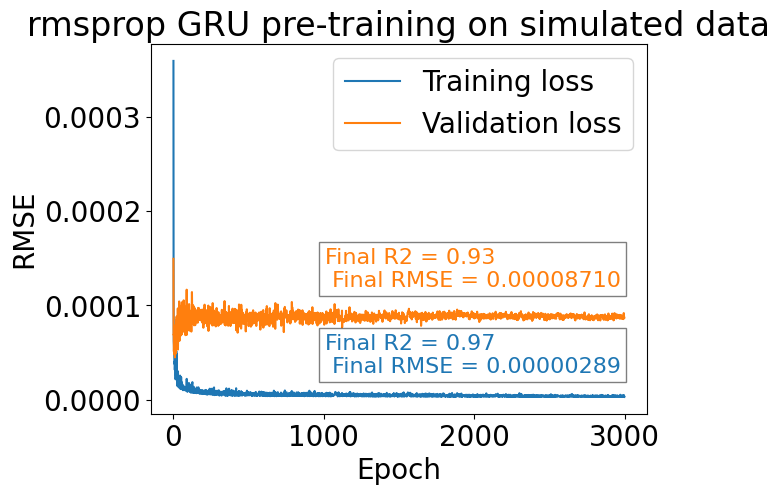

In [32]:
checkpoint=torch.load(stats_save)
train_losses=checkpoint['train_losses']
val_losses=checkpoint['val_losses']
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
fig= plt.plot(figsize=(6, 10)) 
train_line, = plt.plot(train_losses, label="Training loss") 
val_line, = plt.plot(val_losses, label="Validation loss")
plt.title(opt_name + " GRU pre-training on simulated data")
plt.text(0.35, 0.10, "Final R2 = %0.2f\n Final RMSE = %0.8f" % (train_R2, train_loss), ha="left", va="bottom", color=train_line.get_color(), fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.35, 0.45, "Final R2 = %0.2f\n Final RMSE = %0.8f" % (val_R2, val_loss), ha="left", va="top", color=val_line.get_color(), fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()